**Predicción de la Demanda de Productos: Limpieza, Procesamiento y Modelado**

**Etapa proyecto: Pre Processing**


**Objetivo**

El objetivo de este notebook es desarrollar un modelo de aprendizaje automático para predecir la demanda de productos a partir de datos históricos. Se realiza un flujo completo que incluye:

**1.- Limpieza y Preprocesamiento de Datos:**
Tratamiento de valores nulos y duplicados.
Codificación de variables categóricas y transformación de fechas.
Normalización y escalado de características.

**2.- Entrenamiento del Modelo:**
Entrenamiento de un modelo de regresión utilizando el 80% de los datos.

**3.- Validación del Modelo:**
Evaluación del modelo mediante métricas como el error cuadrático medio (MSE), error absoluto medio (MAE) y el coeficiente de determinación (R²).
Visualización de los resultados para analizar el desempeño del modelo.

Este notebook está diseñado para trabajar con el conjunto de datos de entrenamiento, que corresponde al 80% de los datos históricos disponibles.

In [58]:

## Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import os
import pickle

# Configurar opciones de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Cargar el dataset
training_path = '../data/training.csv'


In [61]:
# Verificar que el archivo de entrenamiento exista
if not os.path.exists(training_path):
    print(f"Archivo no encontrado: {os.path.abspath(training_path)}")
    print("Verifica que el archivo esté en la ubicación correcta.")
else:
    print("El archivo existe.")

El archivo existe.


In [ ]:
   # Cargar los datos de entrenamiento
df_train = pd.read_csv(training_path)

# Exploración inicial de los datos
print("Primeros registros del dataset de entrenamiento:")
df_train.head()

Primeros registros del dataset de entrenamiento:


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-11-19,S001,P0020,Toys,North,425,179,100,189.52,44.93,10,Snowy,1,44.70,Spring
1,2023-06-29,S001,P0006,Toys,South,177,149,197,154.92,35.59,0,Sunny,1,32.46,Winter
2,2022-03-10,S001,P0010,Toys,West,284,52,46,66.90,75.52,15,Sunny,1,73.16,Summer
3,2022-02-07,S001,P0001,Electronics,South,244,62,105,73.41,11.34,5,Rainy,0,9.63,Spring
4,2022-06-23,S001,P0015,Electronics,East,488,43,67,54.18,89.58,5,Snowy,1,87.59,Autumn


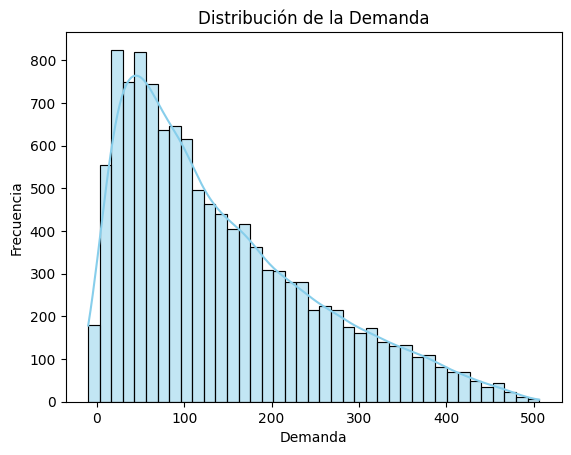

In [99]:
# Visualizar la distribución de la demanda
sns.histplot(df_train['Demand Forecast'], kde=True, color='skyblue')
plt.title("Distribución de la Demanda")
plt.xlabel("Demanda")
plt.ylabel("Frecuencia")
plt.show()

In [63]:
# Verificar la estructura del dataset
print("\nInformación del dataset:")
print(df_train.info())

# Descripción estadística inicial
print("\nDescripción estadística del dataset:")
print(df_train.describe())

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(df_train.isnull().sum())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                11696 non-null  object 
 1   Store ID            11696 non-null  object 
 2   Product ID          11696 non-null  object 
 3   Category            11696 non-null  object 
 4   Region              11696 non-null  object 
 5   Inventory Level     11696 non-null  int64  
 6   Units Sold          11696 non-null  int64  
 7   Units Ordered       11696 non-null  int64  
 8   Demand Forecast     11696 non-null  float64
 9   Price               11696 non-null  float64
 10  Discount            11696 non-null  int64  
 11  Weather Condition   11696 non-null  object 
 12  Holiday/Promotion   11696 non-null  int64  
 13  Competitor Pricing  11696 non-null  float64
 14  Seasonality         11696 non-null  object 
dtypes: float64(3), int64(5), ob

In [97]:
# Identificar columnas numéricas
numeric_columns = df_train.select_dtypes(include=['number']).columns

# Rellenar valores nulos en columnas numéricas con la media de cada columna
df_train[numeric_columns] = df_train[numeric_columns].fillna(df_train[numeric_columns].mean())

# Verificar que ya no haya valores nulos
print("\nValores nulos después de la limpieza:")
print(df_train.isnull().sum())



Valores nulos después de la limpieza:
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
Days_Since_Start      0
dtype: int64


In [92]:
# Procesar la columna Date
# Convertir la columna 'Date' a formato datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Crear una nueva columna con el número de días desde la fecha más antigua
df_train['Days_Since_Start'] = (df_train['Date'] - df_train['Date'].min()).dt.days

# Eliminar la columna original 'Date' (si no es necesaria directamente)
df_train.drop(columns=['Date'], inplace=True)

# Codificar variables categóricas
categorical_columns = ['Category', 'Region', 'Weather Condition', 'Seasonality']
for col in categorical_columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])

print("\nDatos después de procesar la columna 'Date' y codificar variables categóricas:")
print(df_train.head())


Datos después de procesar la columna 'Date' y codificar variables categóricas:
  Store ID Product ID  Category  Region  Inventory Level  Units Sold  \
0     S001      P0020         4       1              425         179   
1     S001      P0006         4       2              177         149   
2     S001      P0010         4       3              284          52   
3     S001      P0001         1       2              244          62   
4     S001      P0015         1       0              488          43   

   Units Ordered  Demand Forecast  Price  Discount  Weather Condition  \
0            100           189.52  44.93        10                  2   
1            197           154.92  35.59         0                  3   
2             46            66.90  75.52        15                  3   
3            105            73.41  11.34         5                  1   
4             67            54.18  89.58         5                  2   

   Holiday/Promotion  Competitor Pricing  Season

In [93]:
# Separar características y columna objetivo
target_column = 'Demand Forecast'  # Cambia según tu columna objetivo
features = [col for col in df_train.columns if col != target_column]

X = df_train[features]
y = df_train[target_column]

# Excluir columnas no numéricas
X = df_train[features].select_dtypes(include=[np.number])

In [94]:
# Escalar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")

Tamaño del conjunto de entrenamiento: (9356, 12)
Tamaño del conjunto de validación: (2340, 12)


In [95]:
# Entrenar el modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [96]:
# Validar el modelo
y_pred = model.predict(X_val)

# Evaluar el modelo
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\nResultados de validación:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


Resultados de validación:
MSE: 80.56336213482052
MAE: 7.68286871794872
R2: 0.9933640604988171


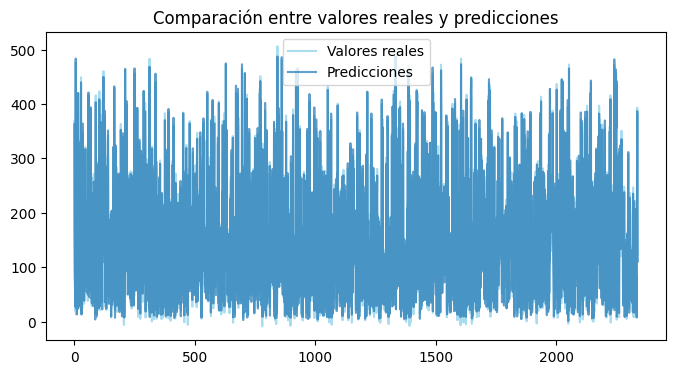

In [91]:
# Visualización de resultados
plt.figure(figsize=(8, 4))
plt.plot(y_val.values, label='Valores reales', color='skyblue', alpha=0.7)
plt.plot(y_pred, label='Predicciones', alpha=0.7)
plt.legend()
plt.title("Comparación entre valores reales y predicciones")
plt.show()

In [98]:
# Guardar el modelo y el escalador
model_dir = '../models/'
os.makedirs(model_dir, exist_ok=True)  # Crear el directorio si no existe

with open(os.path.join(model_dir, 'model.pkl'), 'wb') as f:
    pickle.dump(model, f)

with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print("\nModelo y escalador guardados correctamente.")


Modelo y escalador guardados correctamente.
